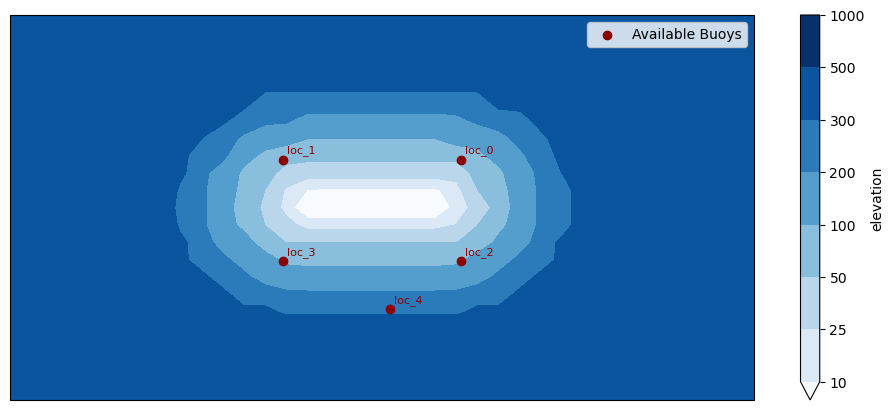

In [1]:
import pandas as pd
import xarray as xr
from utils.plotting import plot_selected_bathy

bathy = xr.open_dataarray("inputs/bathymetry_ISLAND_lonlat.nc")
locations = {
    f"loc_{i}": (lon, lat)
    for i, (lon, lat) in enumerate(
        pd.read_csv("templates/locations.loc", sep=" ", header=None).values
    )
}

plot_selected_bathy(
    bathy=bathy,
    buoys=locations,
)

In [2]:
from bluemath_tk.topo_bathy.swan_grid import generate_grid_parameters

grid_parameters = generate_grid_parameters(bathy_data=bathy)
grid_parameters

Please enter the following parameters:


{'xpc': -3.6283266666666667,
 'ypc': 43.48486065217392,
 'alpc': 0.0,
 'xlenc': 0.10453333333333337,
 'ylenc': 0.0642686956521672,
 'mxc': 35,
 'myc': 22,
 'xpinp': -3.6283266666666667,
 'ypinp': 43.48486065217392,
 'alpinp': 0.0,
 'mxinp': 35,
 'myinp': 22,
 'dxinp': 0.002986666666666693,
 'dyinp': 0.0029213043478293343}

## Create SWAN cases

In [3]:
from bluemath_tk.waves.binwaves import generate_swan_cases

# Generate swan model parameters

swan_cases_df = (
    generate_swan_cases(
        # direction_sector = [225,135],
        # direction_sector = [310,40],
    )
    .astype(float)
    .to_dataframe()
    .reset_index()
)
swan_cases_df

,dir,freq,hs,tp,spr,gamma
0,7.5,0.035000,1.0,28.5714,2.0,50.0
1,7.5,0.038487,1.0,25.9828,2.0,50.0
2,7.5,0.042321,1.0,23.6287,2.0,50.0
3,7.5,0.046538,1.0,21.4878,2.0,50.0
4,7.5,0.051175,1.0,19.5410,2.0,50.0
...,...,...,...,...,...,...
691,352.5,0.341967,0.1,2.9243,2.0,50.0
692,352.5,0.376037,0.1,2.6593,2.0,50.0
693,352.5,0.413501,0.1,2.4184,2.0,50.0
694,352.5,0.454698,0.1,2.1993,2.0,50.0


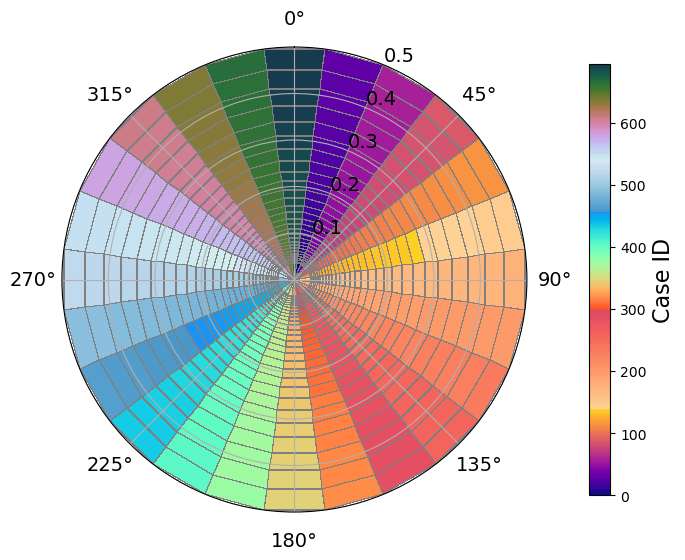

In [4]:
import numpy as np
from bluemath_tk.waves.binwaves import plot_selected_cases_grid

# Plot the cases grid

plot_selected_cases_grid(
    frequencies=np.array(np.unique(swan_cases_df["freq"])),
    directions=np.array(np.unique(swan_cases_df["dir"])),
    figsize=(8, 8),
)

## Build and run SWAN cases

In [5]:
from bluemath_tk.wrappers.swan.swan_wrapper import generate_fixed_parameters

fixed_parameters = generate_fixed_parameters(
    grid_parameters=grid_parameters,
    freq_array=swan_cases_df["freq"],
    dir_array=swan_cases_df["dir"],
)
fixed_parameters

Distribución direccional: CIRCLE


{'xpc': -3.6283266666666667,
 'ypc': 43.48486065217392,
 'alpc': 0.0,
 'xlenc': 0.10453333333333337,
 'ylenc': 0.0642686956521672,
 'mxc': 35,
 'myc': 22,
 'xpinp': -3.6283266666666667,
 'ypinp': 43.48486065217392,
 'alpinp': 0.0,
 'mxinp': 35,
 'myinp': 22,
 'dxinp': 0.002986666666666693,
 'dyinp': 0.0029213043478293343,
 'dir_dist': 'CIRCLE',
 'dir1': None,
 'dir2': None,
 'freq_discretization': 29,
 'dir_discretization': 24,
 'mdc': 24,
 'flow': 0.035,
 'fhigh': 0.5}

In [6]:
import os
from bluemath_tk.wrappers.swan.swan_wrapper import BinWavesWrapper


# Define the input templates and output directory for the wrapper
templates_dir = "templates"
# templates_name =
output_dir = os.path.join(os.getcwd(), "ISLAND_CASES")

# Create an instance of the SWAN model wrapper

swan_wrapper = BinWavesWrapper(
    templates_dir=templates_dir,
    metamodel_parameters=swan_cases_df.to_dict(orient="list"),
    fixed_parameters=fixed_parameters,
    output_dir=output_dir,
)

2025-06-19 10:22:56,605 - BinWavesWrapper - WARNING - Parameter dir is not in the default_parameters
2025-06-19 10:22:56,606 - BinWavesWrapper - WARNING - Parameter freq is not in the default_parameters
2025-06-19 10:22:56,606 - BinWavesWrapper - WARNING - Parameter hs is not in the default_parameters
2025-06-19 10:22:56,607 - BinWavesWrapper - WARNING - Parameter tp is not in the default_parameters
2025-06-19 10:22:56,607 - BinWavesWrapper - WARNING - Parameter spr is not in the default_parameters
2025-06-19 10:22:56,607 - BinWavesWrapper - WARNING - Parameter gamma is not in the default_parameters


In [7]:
# Build the input files

swan_wrapper.build_cases(mode="one_by_one")
swan_cases_df.to_csv(os.path.join(output_dir, "swan_cases.csv"), index=False)

In [ ]:
# Run the model

swan_wrapper.run_cases_in_background(launcher="docker_serial", num_workers=20)

In [12]:
# Monitor running cases

swan_wrapper.monitor_cases(value_counts="simple")

Status
100 %     696
Name: count, dtype: int64

In [13]:
# Post-process the output files

cases_bulk_parameters = swan_wrapper.postprocess_cases()
cases_bulk_parameters

<xarray.Dataset> Size: 7MB
Dimensions:   (case_num: 696, Yp: 23, Xp: 36)
Coordinates:
  * Xp        (Xp) float32 144B -3.628 -3.625 -3.622 ... -3.53 -3.527 -3.524
  * Yp        (Yp) float32 92B 43.48 43.49 43.49 43.49 ... 43.54 43.55 43.55
  * case_num  (case_num) int64 6kB 0 1 2 3 4 5 6 ... 689 690 691 692 693 694 695
Data variables:
    Hsig      (case_num, Yp, Xp) float32 2MB 0.6812 0.6837 ... 0.1317 0.1317
    Tm02      (case_num, Yp, Xp) float32 2MB 28.57 28.57 28.57 ... 1.213 1.213
    Dir       (case_num, Yp, Xp) float32 2MB 1.335 1.451 1.674 ... 0.0 0.0 0.0

/home/tausiaj/GitHub-GeoOcean/BlueMath_tk/bluemath_tk/core/operations.py:349: RuntimeWarning: invalid value encountered in multiply
  x_rad = x_deg * np.pi / 180
/home/tausiaj/miniforge3/envs/bluemath-dev/lib/python3.12/site-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


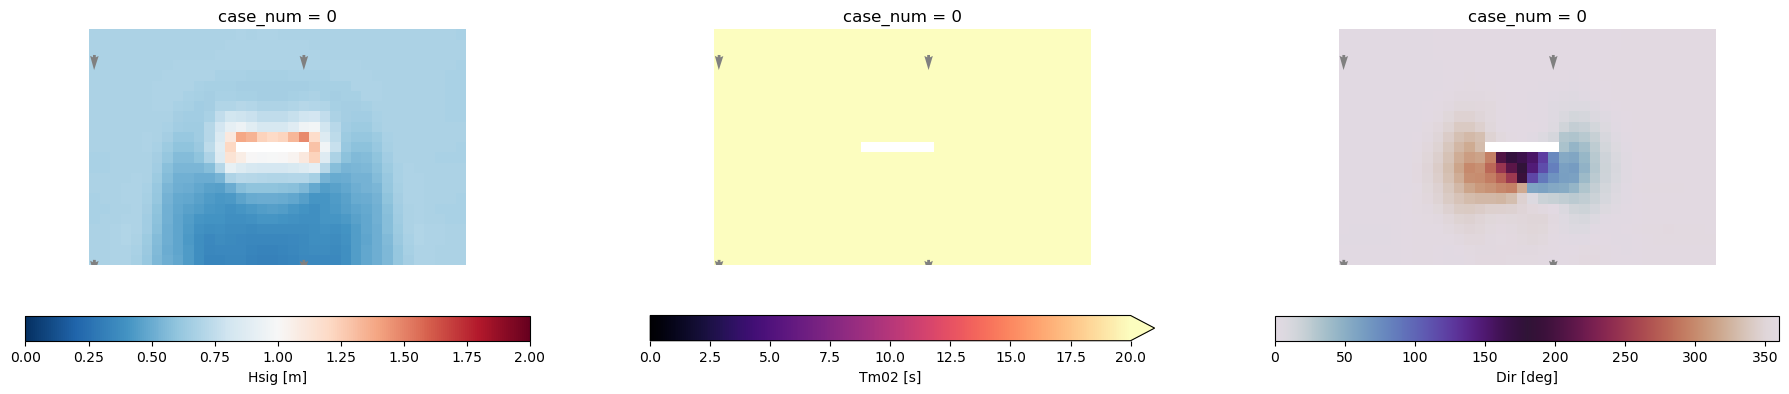

In [14]:
from utils.plotting import plot_case_variables

plot_case_variables(
    data=cases_bulk_parameters.isel(case_num=0),
    step=20,
    vmax_hs=2,
)

## Plot ALL pre-run cases

/home/tausiaj/miniforge3/envs/bluemath-dev/lib/python3.12/site-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


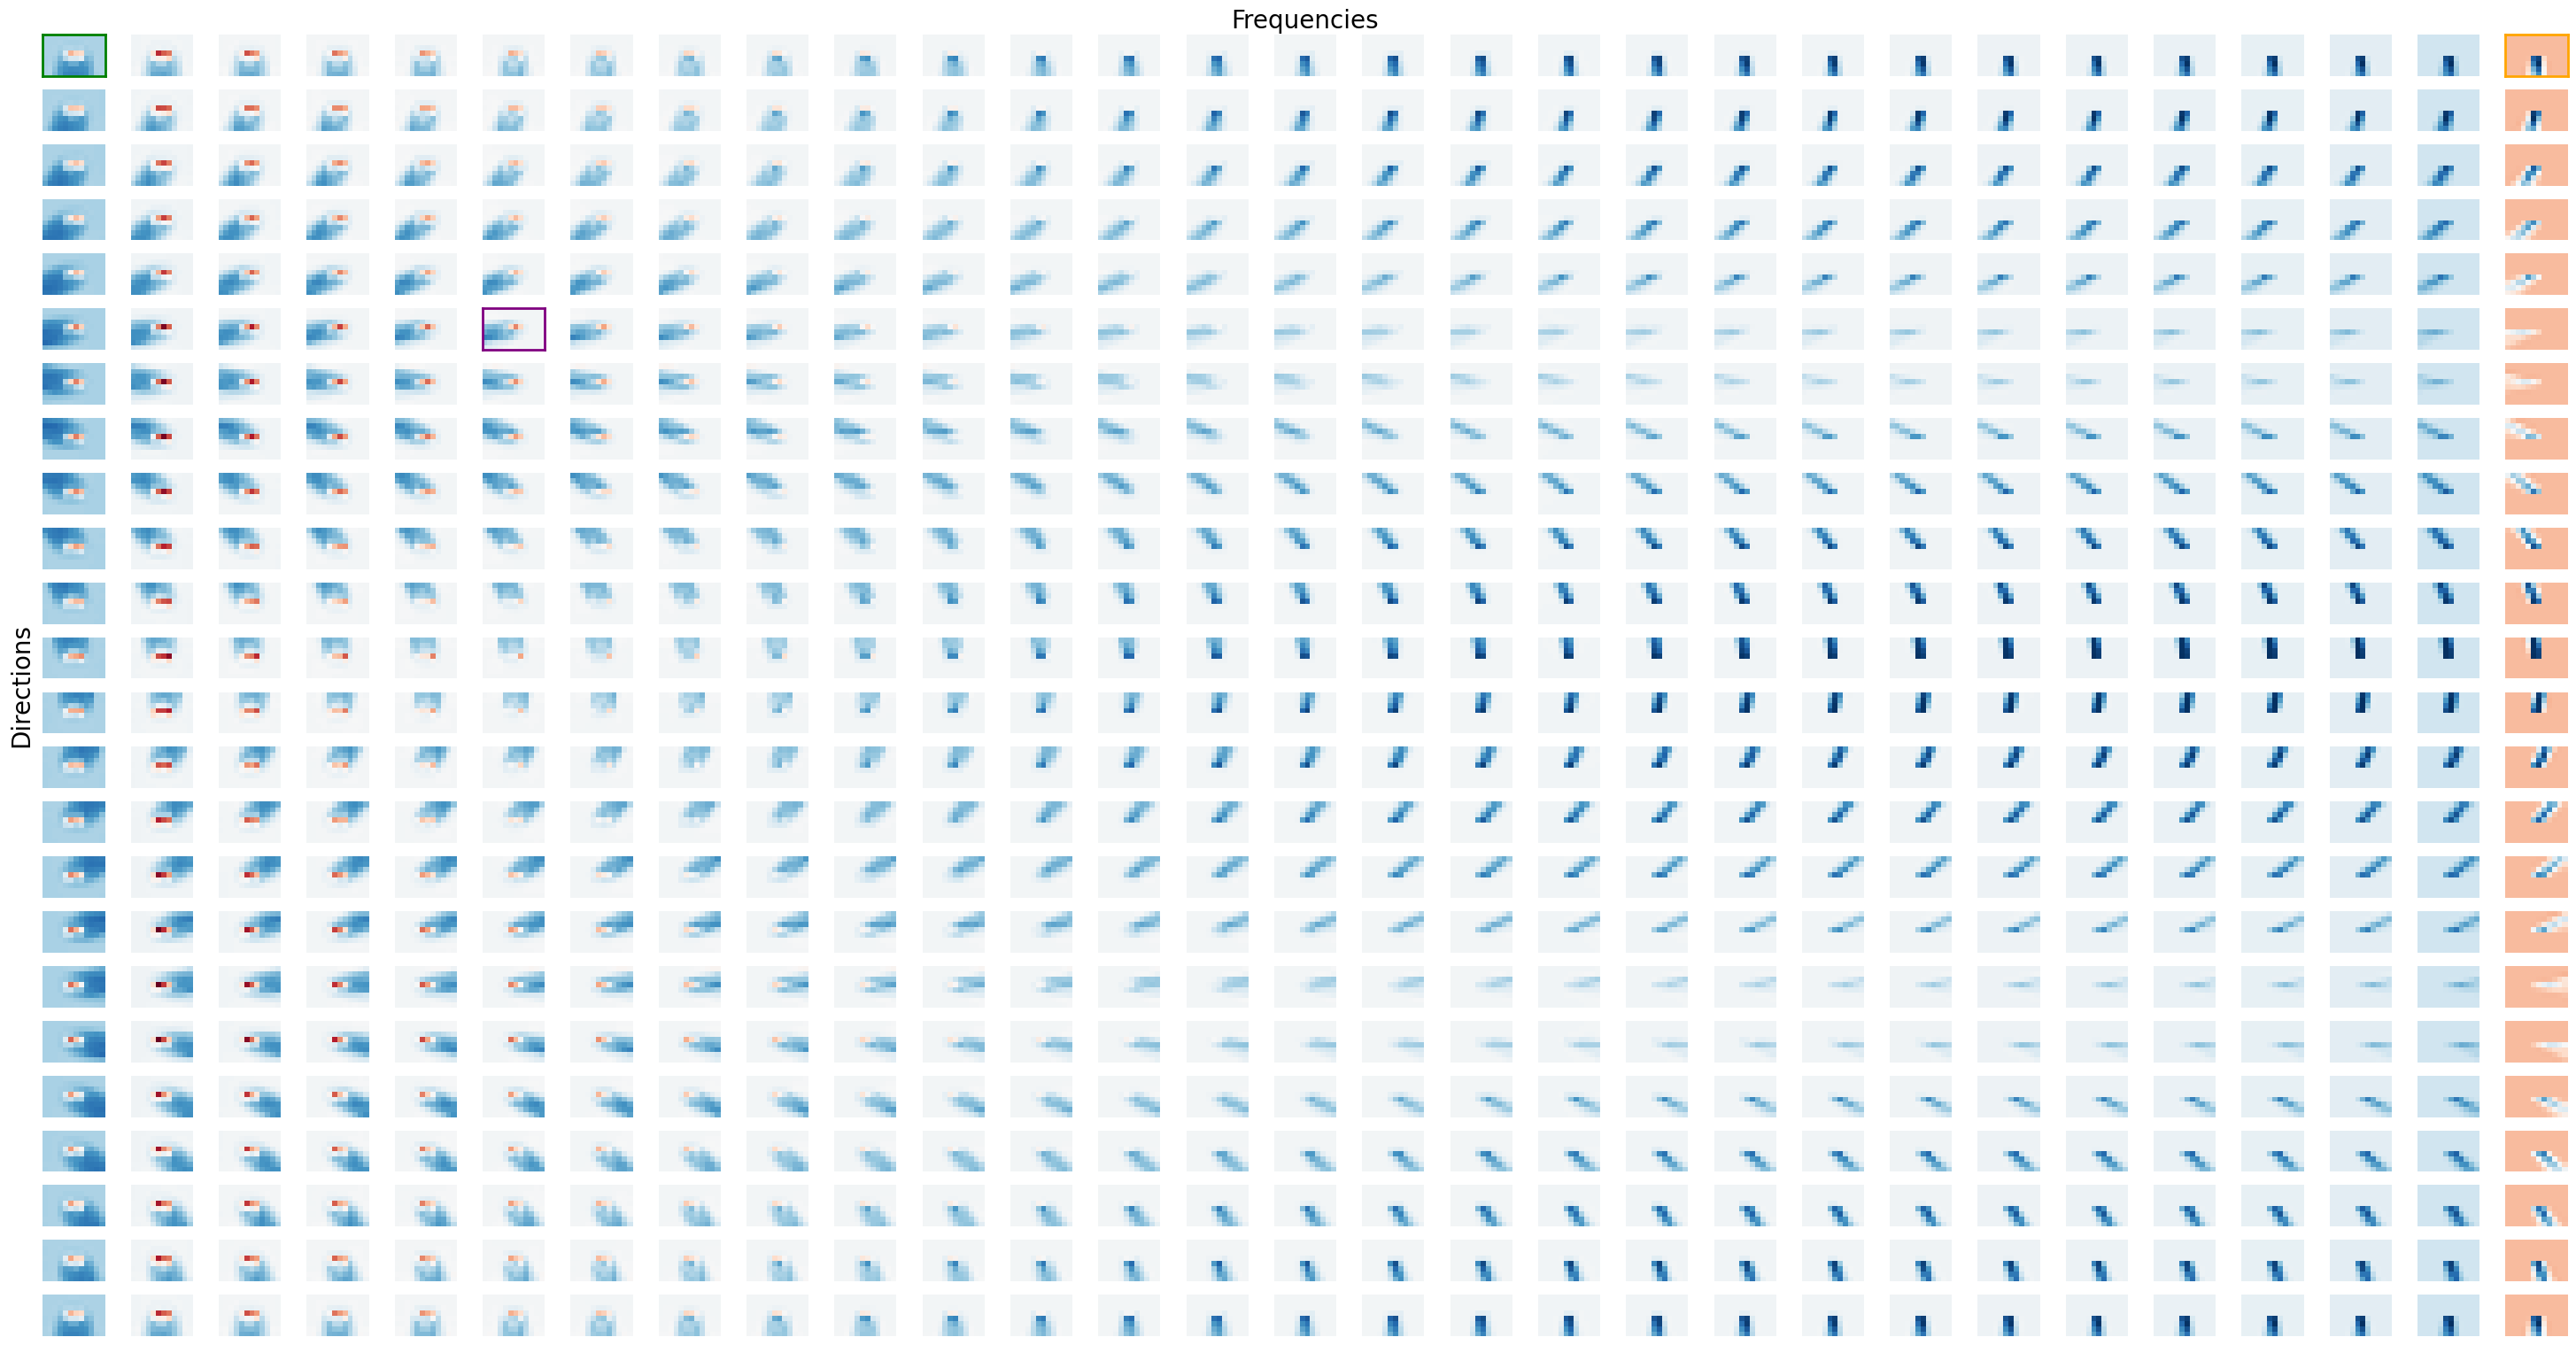

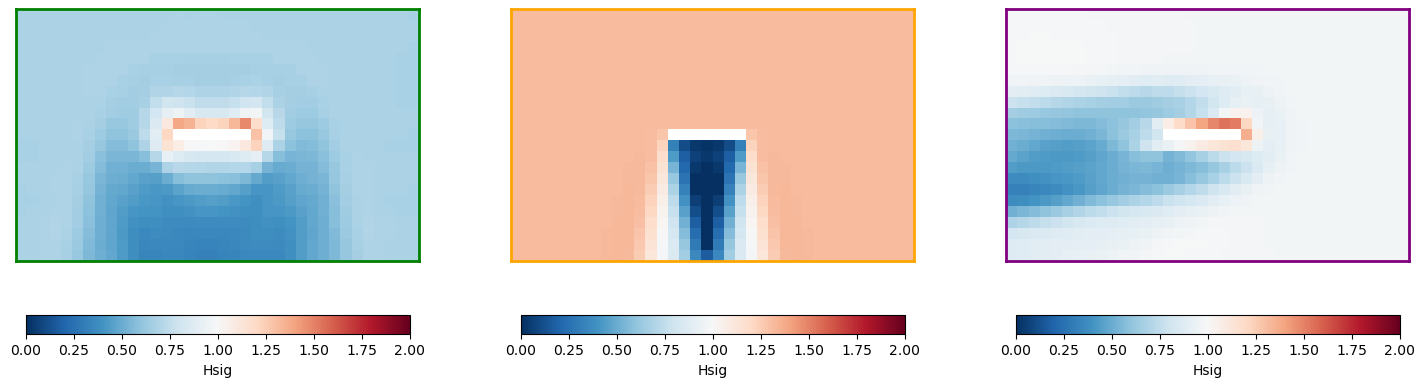

In [15]:
from utils.plotting import plot_cases_grid

plot_cases_grid(
    data=cases_bulk_parameters.Hsig.where(
        cases_bulk_parameters.case_num.isin(
            swan_cases_df.where(swan_cases_df["hs"] == 1.0).dropna().index.values
        ),
        cases_bulk_parameters.Hsig * 10,
    ),
    cases_to_plot=[0, 28, 150],
    num_directions=len(swan_cases_df["dir"].unique()),
    num_frequencies=len(swan_cases_df["freq"].unique()),
)

## Extract kp coefficients

In [17]:
from bluemath_tk.waves.binwaves import process_kp_coefficients

list_of_input_spectra = [
    os.path.join(case_dir, "input_spectra_N.bnd")
    for case_dir in swan_wrapper.cases_dirs
]
list_of_output_spectra = [
    os.path.join(case_dir, "output.spec") for case_dir in swan_wrapper.cases_dirs
]

kp_coefficients = process_kp_coefficients(
    list_of_input_spectra=list_of_input_spectra,
    list_of_output_spectra=list_of_output_spectra,
)
kp_coefficients

<xarray.DataArray 'efth' (case_num: 696, site: 5, freq: 29, dir: 24)> Size: 19MB
array([[[[7.93902792e-01, 3.02855353e-01, 6.79961183e-02, ...,
          7.29675327e-03, 0.00000000e+00, 2.95237863e-01],
         [3.20736407e-04, 8.01841018e-05, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 8.01841018e-05],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[2.69325586e-01, 0.00000000e+00, 7.72429250e-03, ...,
          6.21884365e-02, 3.01483865e-01, 7.80390000e-01],
         [7.88193112e-05, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 7.88193112e-05, 3.15277245e-04],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [3.02462939e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 5.21722223e-01]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.30638880e-03, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 3.82640896e-06]]]])
Coordinates:
  * case_num  (case_num) int64 6kB 0 1 2 3 4 5 6 ... 689 690 691 692 693 694 695
  * site      (site) int64 40B 1 2 3 4 5
  * freq      (freq) float64 232B 0.035 0.0385 0.0423 ... 0.4135 0.4547 0.5
  * dir       (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
    time      datetime64[ns] 8B 2025-06-19T10:25:00
    lat       float64 8B 0.0
    lon       float64 8B 0.0

In [23]:
# TODO: Chenge UTM to lat, lon if needed, but for now the rest of the codes run with utm_x, utm_y
kp_coefficients.to_dataset(name="kps").drop(["time"]).assign_coords(
    utm_x=(
        ("site"),
        pd.read_csv("templates/locations.loc", sep=" ", header=None)[0].values,
    ),
    utm_y=(
        ("site"),
        pd.read_csv("templates/locations.loc", sep=" ", header=None)[1].values,
    ),
).to_netcdf("outputs/kp_coefficients.nc")

/tmp/ipykernel_1431738/3929241168.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  kp_coefficients.to_dataset(name="kps").drop(["time"]).assign_coords(
